In [25]:
import sys
import os
sys.path.append(os.path.abspath('../..'))

from financerag.tasks import FinDER

import numpy as np 
import pandas as pd
import torch

# For retrieval
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from sentence_transformers import CrossEncoder
from langchain.text_splitter import RecursiveCharacterTextSplitter

# For generation
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.vectorstores import Chroma
from transformers import pipeline
from langchain.llms import HuggingFacePipeline

In [2]:
import warnings

warnings.filterwarnings('ignore')

## Read Data

In [3]:
data_folder_path = os.path.join('../..', 'data')
query_df = pd.read_csv(os.path.join(data_folder_path, "FinDER/queries.csv"), index_col=0)
documents_df = pd.read_csv(os.path.join(data_folder_path, "FinDER/corpus.csv"), index_col=0)
documents_df.dropna(subset=['text'], inplace=True)

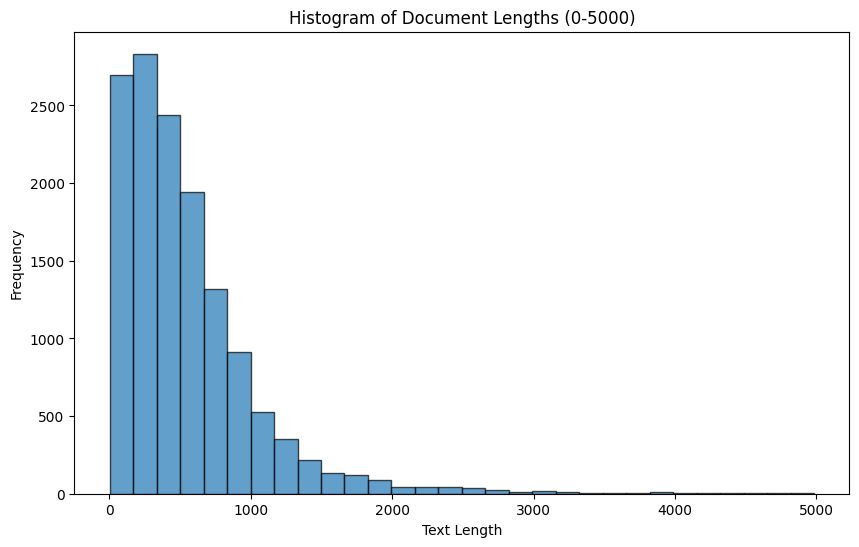

In [104]:
import matplotlib.pyplot as plt

# Filter the documents to only include those with text length in the range 0-5000
filtered_documents_df = documents_df[(documents_df['text_length'] >= 0) & (documents_df['text_length'] <= 5000)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_documents_df['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Document Lengths (0-5000)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Initiliaze Database

In [5]:
embedder = HuggingFaceEmbeddings(model_name="msmarco-distilbert-base-v4")

persist_directory = ".chroma"

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=256,  # Define chunk size
    chunk_overlap=32  # Define overlap to maintain context between chunks
)

docs = []
for id, text in documents_df.text.items():
    # Split the document into chunks
    chunks = text_splitter.split_text(text)
    
    # Create a Document object for each chunk but store the parent document ID in the metadata
    for i, chunk in enumerate(chunks):
        doc = Document(page_content=chunk, metadata={"id": str(id), "chunk_index": i})
        docs.append(doc)

if os.path.exists(persist_directory):
    # Load the existing ChromaDB
    chroma_db = Chroma(persist_directory=persist_directory, embedding_function=embedder)
    print("Loaded existing ChromaDB from .chroma")
else:
    # Create ChromaDB and store the documents
    chroma_db = Chroma.from_documents(
        documents=docs,
        embedding=embedder,
        persist_directory=persist_directory,  
    )
    print("Created new ChromaDB and saved to .chroma")


Created new ChromaDB and saved to .chroma


## Retrieve

In [6]:
retriever = chroma_db.as_retriever(search_kwargs={"k": 100})

In [7]:
retrieved_df = pd.DataFrame([[{} ] for _ in query_df.index], index=query_df.index, columns=["Documents"])

In [8]:
for idx, query in query_df.text.items():

    retrieved = retriever.invoke(query)

    retrieved = {
        str(doc.metadata["id"]):  1
        for doc in retrieved
    }
    retrieved_df.loc[idx]["Documents"] = retrieved

retrieved_results = retrieved_df["Documents"].to_dict()

## Re-Rank

In [9]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def sigmoid(x):
    return 1 / (1 + torch.exp(-torch.tensor(x)))

for idx, query in query_df.text.items():
    for doc_id in retrieved_results[idx]:

        raw_score = cross_encoder.predict((query, documents_df.loc[doc_id].text))
        normalized_score = sigmoid(raw_score).item()

        retrieved_results[idx][doc_id] = normalized_score
    
    retrieved_results[idx] = dict(sorted(retrieved_results[idx].items(), key=lambda item: item[1], reverse=True))

## Evaluate Retrieval

In [10]:
finder_task = FinDER()

A Hugging Face repository is provided. This will override the data_folder, prefix, and *_file arguments.
Using the latest cached version of the dataset since Linq-AI-Research/FinanceRAG couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'FinDER' at /Users/emrekuru/.cache/huggingface/datasets/Linq-AI-Research___finance_rag/FinDER/0.0.0/ba6f7470152e76b389ad48e3997f15381e6aecae (last modified on Mon Oct 21 09:52:22 2024).


In [11]:
qrels = pd.read_csv('../../data/resources/finder_qrels.tsv', sep='\t')

In [12]:
qrels_dict = {}
for index, row in qrels.iterrows():
    key = row['query_id']
    if key not in qrels_dict:
        qrels_dict[key] = {}
    qrels_dict[key][row['corpus_id']] = row['score']

In [13]:
k_values = [10, 50, 100]
results = finder_task.evaluate(qrels=qrels_dict, results=retrieved_results, k_values=k_values)

In [14]:
metrics_df = pd.DataFrame(index=k_values, columns=["MAP", "NDCG", "P@K", "R@K"])

metrics_df["MAP"] = [results[1][f"MAP@{k}"] for k in k_values]
metrics_df["NDCG"] = [results[0][f"NDCG@{k}"] for k in k_values]
metrics_df["P@K"] = [results[3][f"P@{k}"] for k in k_values]
metrics_df["R@K"] = [results[2][f"Recall@{k}"] for k in k_values]

metrics_df

,MAP,NDCG,P@K,R@K
10,0.24140,0.27449,0.04375,0.35938
50,0.25273,0.32490,0.01500,0.56484
100,0.25273,0.32490,0.00750,0.56484


WİTH ONLY RETRİEVAL

| K   | MAP     | NDCG    | P@K     | R@K    |
|-----|---------|---------|---------|--------|
| 10  | 0.00781 | 0.00986 | 0.00156 | 0.01562|
| 50  | 0.01750 | 0.06159 | 0.00656 | 0.24844|
| 100 | 0.02224 | 0.11573 | 0.00781 | 0.5609 |

WİTH RE-RANKİNG - NO CHUNKİNG

| K   | MAP     | NDCG    | P@K     | R@K    |
|-----|---------|---------|---------|--------|
| 10  | 0.22589 | 0.25574 | 0.04063 | 0.32812|
| 50  | 0.23863 | 0.30929 | 0.01469 | 0.54531|
| 100 | 0.23915 | 0.31293 | 0.00781 | 0.56094|

WİTH RECURSİVE CHUNKİNG

| K   | MAP     | NDCG    | P@K     | R@K    |
|-----|---------|---------|---------|--------|
| 10  | 0.24140 | 0.27449 | 0.04375 | 0.35938|
| 50  | 0.25273 | 0.32490 | 0.01500 | 0.56484|
| 100 | 0.25273 | 0.32490 | 0.00750 | 0.56484|

## Generate

In [45]:
model_name = "google/flan-t5-small"
pipe = pipeline("text2text-generation", model=model_name)  
model = HuggingFacePipeline(pipeline=pipe)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [89]:
# Helper Methods

def format_retrieved_docs(docs):
    docs = docs[:5]
    if docs:
        return "\n\n".join([f"\n{doc.page_content}" for doc, score in docs])
    else:
        return "No relevant documents found."
    
def re_rank_docs(query, docs):
    re_ranked_docs = []
    for doc in docs:
        raw_score = cross_encoder.predict((query, doc.page_content))
        normalized_score = sigmoid(raw_score).item()
        re_ranked_docs.append((doc, normalized_score))
    return sorted(re_ranked_docs, key=lambda item: item[1], reverse=True)

In [90]:
template = """Answer the following question based on the context:
Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnablePassthrough.assign(
        context=lambda x: format_retrieved_docs(re_rank_docs( x["question"], retriever.get_relevant_documents(x["question"]))),  
        question=lambda x: x["question"] 
    )
    | prompt  
    | model  
    | StrOutputParser()  
)

In [102]:
# Step 4: Example usage (run the pipeline)
question = query_df.text[0]
print("Question: ", question)
result = chain.invoke({"question": question})
print(f"Answer: {result}")

Question:  What are the service and product offerings from Microsoft
Answer: Microsoft 365, Windows, Microsoft Teams, Search (including Microsoft Edge and Bing Chat)
